# Hypothesis 1 Justice Principles: Descriptive Statistics & Visuals

This notebook analyzes Hypothesis 1 run logs to produce descriptive statistics and publication-ready figures for the justice-principles experiment.

In [20]:
import json
from pathlib import Path
from typing import Any, Dict, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# ==============================================================================
# UNIVERSITY OF BAYREUTH VISUAL DESIGN SYSTEM
# ==============================================================================

# Corporate color palette (Pantone 340C + grayscale companions)
COLORS = {
    "primary_green": "#009260",   # Bayreuth green
    "primary_blue": "#48535A",    # Dark gray for emphasis and headlines
    "primary_orange": "#7F8990",  # Medium gray for secondary series
    "accent_1": "#EBEBE4",        # Light gray for neutral fills
    "dark_gray": "#48535A",
    "medium_gray": "#7F8990",
    "light_gray": "#EBEBE4",
    "background": "#FFFFFF",
    "stayed": "#009260",
    "switched": "#48535A",
    "highlight": "#009260",
}

# Principle-specific colors (mapped to the corporate palette)
PRINCIPLE_COLORS = {
    "Max Avg Income": COLORS["primary_green"],
    "Max Avg + Floor": COLORS["primary_blue"],
    "Max Avg + Range": COLORS["primary_orange"],
    "Max Floor": COLORS["accent_1"],
}

# Display labels for principles (adds periods to abbreviations)
PRINCIPLE_DISPLAY_NAMES = {
    "Max Avg Income": "Max. Avg. Income",
    "Max Avg + Floor": "Max. Avg. + Floor",
    "Max Avg + Range": "Max. Avg. + Range",
    "Max Floor": "Max. Floor",
}

def format_principle_label(name: str) -> str:
    """Return display-friendly label for a principle."""
    return PRINCIPLE_DISPLAY_NAMES.get(name, name)

def format_principle_labels(labels: List[str]) -> List[str]:
    """Vectorised helper for principle labels."""
    return [format_principle_label(label) for label in labels]

# Typography
FONT_SIZES = {
    "title": 14,
    "subtitle": 12,
    "axis_label": 11,
    "tick_label": 10,
    "legend": 10,
    "annotation": 9
}

FONT_FAMILY = "DejaVu Sans"

# Figure dimensions (inches) for concise, aligned layouts
FIG_SIZES = {
    "single": (9, 5),
    "double": (12, 5),
    "triple": (14, 5),
    "wide_single": (11, 5),
    "tall": (9, 7)
}

# Grid and spacing
GRID_ALPHA = 0.2
GRID_LINEWIDTH = 0.6
GRID_LINESTYLE = "-"

plt.rcParams.update({
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "figure.facecolor": COLORS["background"],
    "axes.facecolor": COLORS["background"],
    "axes.edgecolor": COLORS["medium_gray"],
    "axes.linewidth": 1.0,
    "axes.labelsize": FONT_SIZES["axis_label"],
    "axes.titlesize": FONT_SIZES["title"],
    "axes.titleweight": "bold",
    "axes.labelweight": "normal",
    "axes.labelcolor": COLORS["dark_gray"],
    "axes.grid": True,
    "axes.grid.axis": "y",
    "grid.alpha": GRID_ALPHA,
    "grid.linewidth": GRID_LINEWIDTH,
    "grid.linestyle": GRID_LINESTYLE,
    "grid.color": COLORS["light_gray"],
    "xtick.labelsize": FONT_SIZES["tick_label"],
    "ytick.labelsize": FONT_SIZES["tick_label"],
    "xtick.color": COLORS["dark_gray"],
    "ytick.color": COLORS["dark_gray"],
    "legend.fontsize": FONT_SIZES["legend"],
    "legend.framealpha": 0.95,
    "legend.edgecolor": COLORS["medium_gray"],
    "font.family": "sans-serif",
    "font.sans-serif": [FONT_FAMILY],
    "text.color": COLORS["dark_gray"],
    "axes.spines.top": False,
    "axes.spines.right": False,
})

palette_hex = list(dict.fromkeys([
    COLORS["primary_green"],
    COLORS["primary_blue"],
    COLORS["primary_orange"],
    COLORS["accent_1"],
]))

sns.set_theme(
    style="whitegrid",
    context="paper",
    palette=palette_hex
)



## Design System Notes

**University of Bayreuth Palette**
- Bayreuth Green `#009260` anchors positive outcomes and primary series.
- Dark Gray `#48535A` supports structural elements, switcher series, and typography.
- Medium Gray `#7F8990` carries secondary measures and annotations.
- Light Gray `#EBEBE4` is reserved for gridlines, backgrounds, and subtle fills.

**Layout & Typography**
- Horizontal comparisons keep categories aligned across panels.
- Default figure widths between 9" and 12" produce concise, publication-ready visuals.
- DejaVu Sans at 9–14 pt maintains clarity when exporting to reports.

In [21]:
def locate_project_root(markers: Tuple[str, ...] = ("hypothesis_testing", "config")) -> Path:
    """Find the project root by looking for known directories."""
    start = Path.cwd().resolve()
    for candidate in [start, *start.parents]:
        if all((candidate / marker).exists() for marker in markers):
            return candidate
    raise FileNotFoundError("Could not locate project root from current working directory.")


PROJECT_ROOT = locate_project_root()
DATA_DIR = PROJECT_ROOT / "hypothesis_testing" / "hypothesis_1" / "results"

PRINCIPLE_LABELS = {
    "maximizing_average": "Max Avg Income",
    "maximizing_average_floor_constraint": "Max Avg + Floor",
    "maximizing_average_range_constraint": "Max Avg + Range",
    "maximizing_floor": "Max Floor",
    "failure": "Failure",
    None: "None"
}

CERTAINTY_TO_SCORE = {
    "very_unsure": 1,
    "unsure": 1,
    "neutral": 2,
    "sure": 2,
    "very_sure": 3,
    "no_opinion": np.nan,
    None: np.nan
}

WAVE_DEFINITIONS = [
    ("initial_ranking", "Wave 1 - Initial", 1),
    ("ranking_2", "Wave 2 - Post-Explanation", 2),
    ("ranking_3", "Wave 3 - Final Phase 1", 3)
]
FINAL_WAVE = ("Wave 4 - Post-Group", 4)
WAVE_ORDER = [label for _, label, _ in WAVE_DEFINITIONS] + [FINAL_WAVE[0]]


def _resolve_result_path(path: Path) -> Path:
    if not path.is_absolute():
        path = (PROJECT_ROOT / path).resolve()
    return path


def load_runs(data_dir: Path, include_logs: bool = True) -> List[Tuple[str, Dict[str, Any]]]:
    result_paths = {p.resolve() for p in data_dir.glob("hypothesis_1_condition_*_config_results.json")}

    if include_logs:
        logs_dir = data_dir.parent / "terminal_outputs"
        if logs_dir.exists():
            for log_path in logs_dir.glob("hypothesis_1_condition_*_log"):
                try:
                    first_line = log_path.read_text(encoding="utf-8").splitlines()[0]
                except Exception:
                    continue
                parts = first_line.strip().split()
                if parts[:1] == ["CMD:"] and parts[-1].endswith(".json"):
                    candidate = _resolve_result_path(Path(parts[-1]))
                    result_paths.add(candidate)

    runs: List[Tuple[str, Dict[str, Any]]] = []
    for file_path in sorted(result_paths):
        if not file_path.exists():
            print(f"Warning: expected result file missing: {file_path}")
            continue
        with file_path.open("r", encoding="utf-8") as f:
            runs.append((file_path.stem, json.load(f)))

    runs.sort(key=lambda item: item[0])
    return runs


def extract_run_metrics(run_id: str, run_data: Dict[str, Any]) -> Dict[str, Any]:
    general = run_data.get("general_information", {})
    voting = run_data.get("voting_history", {})
    return {
        "run_id": run_id,
        "consensus_reached": general.get("consensus_reached"),
        "consensus_principle": PRINCIPLE_LABELS.get(general.get("consensus_principle"), general.get("consensus_principle")),
        "rounds_to_outcome": general.get("rounds_conducted_phase_2"),
        "max_rounds": general.get("max_rounds_phase_2"),
        "total_vote_attempts": voting.get("total_vote_attempts"),
        "successful_votes": voting.get("successful_votes"),
        "total_vote_rounds": len(voting.get("vote_rounds", []))
    }


def extract_vote_rounds(run_id: str, run_data: Dict[str, Any]) -> List[Dict[str, Any]]:
    rounds: List[Dict[str, Any]] = []
    for idx, round_info in enumerate(run_data.get("voting_history", {}).get("vote_rounds", []), start=1):
        rounds.append({
            "run_id": run_id,
            "round_index": idx,
            "round_number": round_info.get("round_number"),
            "vote_type": round_info.get("vote_type"),
            "consensus_reached": round_info.get("consensus_reached", False),
            "agreed_principle": round_info.get("agreed_principle"),
            "agreed_principle_label": PRINCIPLE_LABELS.get(round_info.get("agreed_principle"), round_info.get("agreed_principle")),
            "agreed_constraint": round_info.get("agreed_constraint"),
            "participant_count": len(round_info.get("participant_votes", []))
        })
    return rounds


def extract_rankings(run_id: str, run_data: Dict[str, Any]) -> Tuple[List[Dict[str, Any]], List[Dict[str, Any]]]:
    top_choice_rows: List[Dict[str, Any]] = []
    long_rows: List[Dict[str, Any]] = []
    agents = run_data.get("agents", [])

    for agent in agents:
        agent_name = agent.get("name")
        phase1 = agent.get("phase_1", {})
        for key, wave_label, wave_pos in WAVE_DEFINITIONS:
            container = phase1.get(key)
            ranking_data = container.get("ranking_result") if isinstance(container, dict) else None
            if ranking_data:
                _append_ranking_rows(
                    target_top=top_choice_rows,
                    target_long=long_rows,
                    run_id=run_id,
                    agent_name=agent_name,
                    wave_label=wave_label,
                    wave_pos=wave_pos,
                    ranking_data=ranking_data
                )

        final_ranking = agent.get("phase_2", {}).get("post_group_discussion", {}).get("final_ranking")
        if final_ranking:
            _append_ranking_rows(
                target_top=top_choice_rows,
                target_long=long_rows,
                run_id=run_id,
                agent_name=agent_name,
                wave_label=FINAL_WAVE[0],
                wave_pos=FINAL_WAVE[1],
                ranking_data=final_ranking
            )

    return top_choice_rows, long_rows


def _append_ranking_rows(
    *,
    target_top: List[Dict[str, Any]],
    target_long: List[Dict[str, Any]],
    run_id: str,
    agent_name: str,
    wave_label: str,
    wave_pos: int,
    ranking_data: Dict[str, Any]
) -> None:
    rankings = ranking_data.get("rankings", [])
    if not rankings:
        return

    certainty = ranking_data.get("certainty")
    certainty_score = CERTAINTY_TO_SCORE.get(certainty, np.nan)

    top_principle = None
    for item in rankings:
        principle_name = item.get("principle")
        rank_value = item.get("rank")
        target_long.append({
            "run_id": run_id,
            "agent": agent_name,
            "wave_label": wave_label,
            "wave_position": wave_pos,
            "principle": principle_name,
            "principle_label": PRINCIPLE_LABELS.get(principle_name, principle_name),
            "rank": rank_value,
            "certainty": certainty,
            "certainty_score": certainty_score
        })
        if rank_value == 1 and top_principle is None:
            top_principle = principle_name

    if top_principle is not None:
        target_top.append({
            "run_id": run_id,
            "agent": agent_name,
            "wave_label": wave_label,
            "wave_position": wave_pos,
            "top_principle": top_principle,
            "top_principle_label": PRINCIPLE_LABELS.get(top_principle, top_principle),
            "certainty": certainty,
            "certainty_score": certainty_score
        })

In [22]:

# Load all Hypothesis 1 runs (results + terminal log fallbacks)
runs = load_runs(DATA_DIR)
run_metrics_records: List[Dict[str, Any]] = []
vote_round_records: List[Dict[str, Any]] = []
top_choice_records: List[Dict[str, Any]] = []
long_ranking_records: List[Dict[str, Any]] = []

for run_id, run_data in runs:
    run_metrics_records.append(extract_run_metrics(run_id, run_data))
    vote_round_records.extend(extract_vote_rounds(run_id, run_data))
    top_rows, long_rows = extract_rankings(run_id, run_data)
    top_choice_records.extend(top_rows)
    long_ranking_records.extend(long_rows)

run_metrics = pd.DataFrame(run_metrics_records)
vote_rounds = pd.DataFrame(vote_round_records)
ranking_long = pd.DataFrame(long_ranking_records)
ranking_top = pd.DataFrame(top_choice_records)

ranking_top["wave_label"] = pd.Categorical(ranking_top["wave_label"], categories=WAVE_ORDER, ordered=True)
ranking_long["wave_label"] = pd.Categorical(ranking_long["wave_label"], categories=WAVE_ORDER, ordered=True)

print(f"Loaded {len(runs)} result files.")
run_metrics.head()


Loaded 33 result files.


,run_id,consensus_reached,consensus_principle,rounds_to_outcome,max_rounds,total_vote_attempts,successful_votes,total_vote_rounds
0,hypothesis_1_condition_10_config_results,True,Max Avg + Floor,8,10,1,1,1
1,hypothesis_1_condition_11_config_results,True,Max Avg + Floor,4,10,1,1,1
2,hypothesis_1_condition_12_config_results,True,Max Avg + Floor,7,10,1,1,1
3,hypothesis_1_condition_13_config_results,True,Max Avg + Floor,6,10,1,1,1
4,hypothesis_1_condition_14_config_results,True,Max Avg + Floor,4,10,1,1,1


## Data Summary

In [23]:

num_runs = run_metrics.shape[0]
unique_agents = ranking_top[["run_id", "agent"]].drop_duplicates().shape[0]
num_waves = ranking_top["wave_label"].nunique()
consensus_runs = run_metrics[run_metrics["consensus_reached"] == True].shape[0]

summary_df = pd.DataFrame(
    {
        "Metric": ["Runs", "Consensus runs", "Agent sessions", "Preference waves"],
        "Value": [num_runs, consensus_runs, unique_agents, num_waves]
    }
)

display(summary_df)

expected_agents = unique_agents
coverage = (ranking_top.drop_duplicates(subset=["run_id", "agent", "wave_label"])
                     .groupby("wave_label")
                     .size()
                     .reindex(WAVE_ORDER, fill_value=0))
missing = expected_agents - coverage
coverage_table = pd.DataFrame({"Responses": coverage, "Missing": missing})
display(coverage_table)


,Metric,Value
0,Runs,33
1,Consensus runs,30
2,Agent sessions,165
3,Preference waves,4


/var/folders/wf/_h59fnv53s7476fhw5sn5smh0000gn/T/ipykernel_18792/1307473778.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("wave_label")


,Responses,Missing
wave_label,,
Wave 1 - Initial,165,0
Wave 2 - Post-Explanation,165,0
Wave 3 - Final Phase 1,165,0
Wave 4 - Post-Group,165,0


## Preference Orderings by Wave

Below are frequency tables showing how many agents reported each complete ranking of the four justice principles at each measurement wave. Orderings are shown from most to least popular.

In [24]:
def create_preference_ordering_table(ranking_long_df: pd.DataFrame, wave_name: str) -> pd.DataFrame:
    """
    Create a frequency table of complete preference orderings for a specific wave.
    
    Args:
        ranking_long_df: DataFrame with all ranking data
        wave_name: Name of the wave to analyze
    
    Returns:
        DataFrame showing each unique ordering and its frequency
    """
    # Filter to the specific wave
    wave_data = ranking_long_df[ranking_long_df["wave_label"] == wave_name].copy()
    
    if wave_data.empty:
        return pd.DataFrame({"Note": [f"No data available for {wave_name}"]})
    
    # Get the principle order constant
    principle_labels = ["Max Avg Income", "Max Avg + Floor", "Max Avg + Range", "Max Floor"]
    
    # Create ordering strings for each agent
    orderings = []
    for (run_id, agent), group in wave_data.groupby(["run_id", "agent"]):
        # Sort by rank to get the ordering
        sorted_group = group.sort_values("rank")
        ordering = tuple(sorted_group["principle_label"].tolist())
        orderings.append({
            "run_id": run_id,
            "agent": agent,
            "ordering": ordering
        })
    
    ordering_df = pd.DataFrame(orderings)
    
    # Count frequency of each ordering
    freq_table = ordering_df.groupby("ordering").size().reset_index(name="Count")
    freq_table = freq_table.sort_values("Count", ascending=False).reset_index(drop=True)
    
    # Calculate percentage
    total = freq_table["Count"].sum()
    freq_table["Percentage"] = (freq_table["Count"] / total * 100).round(1)
    
    # Format the ordering as a readable string (1st > 2nd > 3rd > 4th)
    def format_ordering(ordering_tuple):
        if len(ordering_tuple) == 4:
            return f"{ordering_tuple[0]} > {ordering_tuple[1]} > {ordering_tuple[2]} > {ordering_tuple[3]}"
        return str(ordering_tuple)
    
    freq_table["Preference Ordering"] = freq_table["ordering"].apply(format_ordering)
    
    # Reorder columns for display
    freq_table = freq_table[["Preference Ordering", "Count", "Percentage"]]
    
    return freq_table


# Generate tables for all four waves
print("=" * 100)
print("WAVE 1 - INITIAL (After Principle Introduction)")
print("=" * 100)
wave1_table = create_preference_ordering_table(ranking_long, "Wave 1 - Initial")
display(wave1_table)

print("\n" + "=" * 100)
print("WAVE 2 - POST-EXPLANATION (After Detailed Explanation)")
print("=" * 100)
wave2_table = create_preference_ordering_table(ranking_long, "Wave 2 - Post-Explanation")
display(wave2_table)

print("\n" + "=" * 100)
print("WAVE 3 - FINAL PHASE 1 (End of Individual Deliberation)")
print("=" * 100)
wave3_table = create_preference_ordering_table(ranking_long, "Wave 3 - Final Phase 1")
display(wave3_table)

print("\n" + "=" * 100)
print("WAVE 4 - POST-GROUP (After Group Discussion)")
print("=" * 100)
wave4_table = create_preference_ordering_table(ranking_long, "Wave 4 - Post-Group")
display(wave4_table)

# Summary statistics across waves
print("\n" + "=" * 100)
print("SUMMARY: Unique Orderings Per Wave")
print("=" * 100)
summary_data = []
for wave in WAVE_ORDER:
    wave_data = ranking_long[ranking_long["wave_label"] == wave]
    if not wave_data.empty:
        orderings = []
        for (run_id, agent), group in wave_data.groupby(["run_id", "agent"]):
            sorted_group = group.sort_values("rank")
            ordering = tuple(sorted_group["principle_label"].tolist())
            orderings.append(ordering)
        unique_count = len(set(orderings))
        total_count = len(orderings)
        summary_data.append({
            "Wave": wave,
            "Total Responses": total_count,
            "Unique Orderings": unique_count,
            "Diversity Ratio": f"{unique_count}/{total_count} ({unique_count/total_count*100:.1f}%)"
        })

summary_df = pd.DataFrame(summary_data)
display(summary_df)

WAVE 1 - INITIAL (After Principle Introduction)


,Preference Ordering,Count,Percentage
0,Max Avg + Floor > Max Floor > Max Avg + Range ...,100,60.6
1,Max Avg + Floor > Max Avg + Range > Max Floor ...,27,16.4
2,Max Avg + Floor > Max Floor > Max Avg Income >...,21,12.7
3,Max Avg Income > Max Avg + Floor > Max Floor >...,13,7.9
4,Max Avg + Floor > Max Avg Income > Max Floor >...,2,1.2
5,Max Avg Income > Max Avg + Floor > Max Avg + R...,2,1.2



WAVE 2 - POST-EXPLANATION (After Detailed Explanation)


,Preference Ordering,Count,Percentage
0,Max Avg + Floor > Max Floor > Max Avg + Range ...,88,53.3
1,Max Avg + Floor > Max Avg + Range > Max Floor ...,48,29.1
2,Max Avg + Floor > Max Floor > Max Avg Income >...,18,10.9
3,Max Avg + Floor > Max Avg + Range > Max Avg In...,6,3.6
4,Max Avg + Floor > Max Avg Income > Max Floor >...,3,1.8
5,Max Avg + Range > Max Avg + Floor > Max Floor ...,1,0.6
6,Max Avg Income > Max Avg + Floor > Max Floor >...,1,0.6



WAVE 3 - FINAL PHASE 1 (End of Individual Deliberation)


,Preference Ordering,Count,Percentage
0,Max Avg + Floor > Max Floor > Max Avg + Range ...,68,41.2
1,Max Avg + Floor > Max Avg + Range > Max Floor ...,47,28.5
2,Max Avg + Floor > Max Floor > Max Avg Income >...,15,9.1
3,Max Avg + Floor > Max Avg Income > Max Floor >...,9,5.5
4,Max Avg + Floor > Max Avg + Range > Max Avg In...,7,4.2
5,Max Avg Income > Max Avg + Floor > Max Avg + R...,7,4.2
6,Max Avg + Floor > Max Avg Income > Max Avg + R...,5,3.0
7,Max Avg Income > Max Avg + Floor > Max Floor >...,4,2.4
8,Max Floor > Max Avg + Floor > Max Avg + Range ...,3,1.8



WAVE 4 - POST-GROUP (After Group Discussion)


,Preference Ordering,Count,Percentage
0,Max Avg + Floor > Max Floor > Max Avg + Range ...,59,35.8
1,Max Avg + Floor > Max Avg + Range > Max Floor ...,43,26.1
2,Max Avg + Floor > Max Avg Income > Max Avg + R...,16,9.7
3,Max Avg + Floor > Max Floor > Max Avg Income >...,10,6.1
4,Max Avg + Floor > Max Avg Income > Max Floor >...,7,4.2
5,Max Floor > Max Avg Income > Max Avg + Floor >...,7,4.2
6,Max Avg Income > Max Avg + Floor > Max Avg + R...,6,3.6
7,Max Floor > Max Avg + Floor > Max Avg + Range ...,6,3.6
8,Max Floor > Max Avg + Floor > Max Avg Income >...,4,2.4
9,Max Avg + Floor > Max Avg + Range > Max Avg In...,2,1.2



SUMMARY: Unique Orderings Per Wave


,Wave,Total Responses,Unique Orderings,Diversity Ratio
0,Wave 1 - Initial,165,6,6/165 (3.6%)
1,Wave 2 - Post-Explanation,165,7,7/165 (4.2%)
2,Wave 3 - Final Phase 1,165,9,9/165 (5.5%)
3,Wave 4 - Post-Group,165,14,14/165 (8.5%)


## Rounds to Outcome

## Floor Constraint Amounts

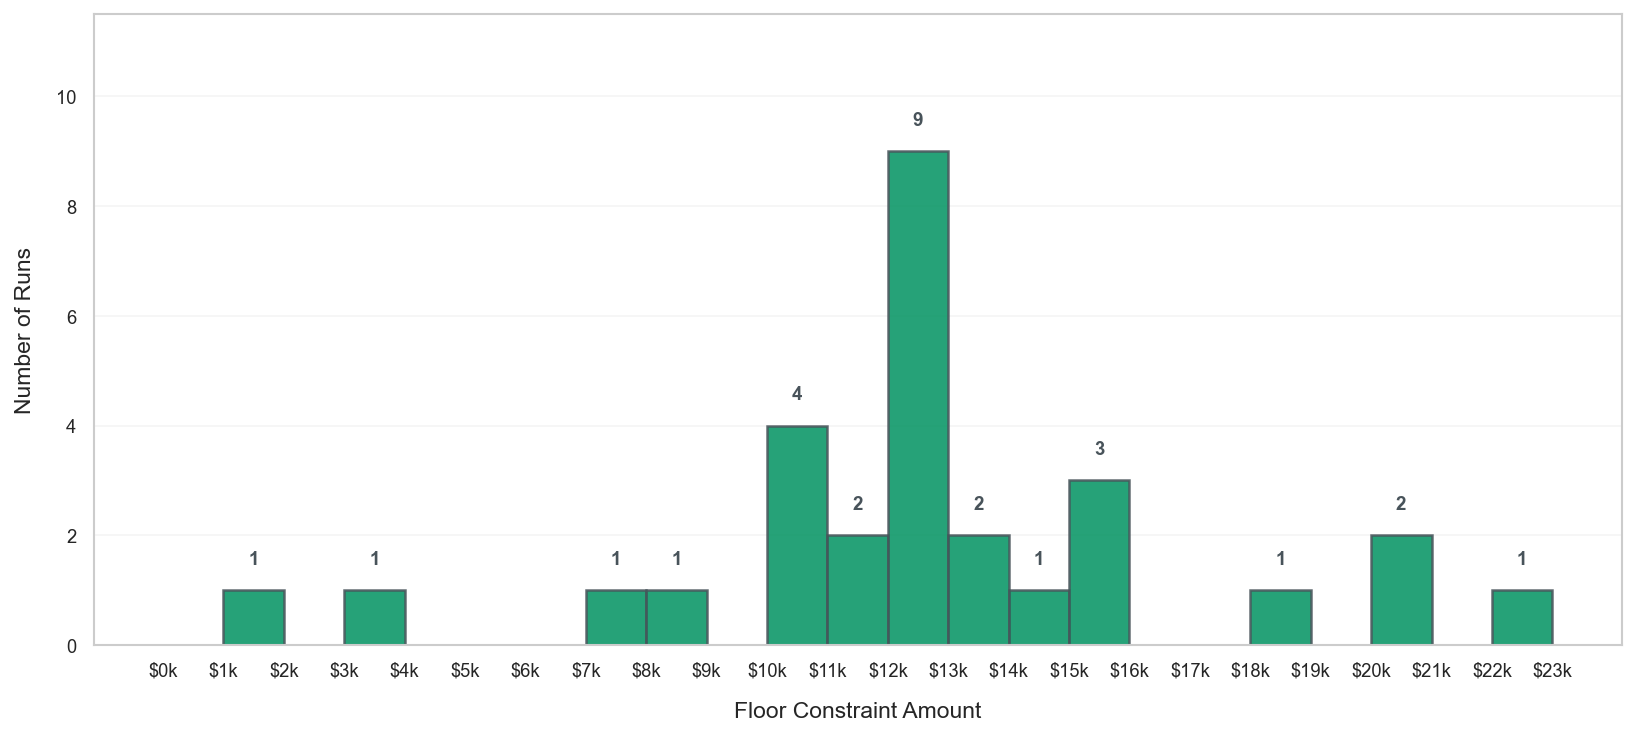


Floor Amount Summary:
  Total votes: 29
  Range: $1,000 - $23,000
  Mean: $12,328  |  Median: $12,000  |  SD: $4,403


In [25]:
parameter_votes = vote_rounds[
    (vote_rounds["consensus_reached"] == True)
    & vote_rounds["agreed_constraint"].notna()
]

if not parameter_votes.empty:
    amounts = parameter_votes["agreed_constraint"].values
    
    # Create bins with $5,000 intervals
    bin_width = 1000
    min_amount = 0
    max_amount = int(np.ceil(amounts.max() / bin_width) * bin_width)
    bins = np.arange(min_amount, max_amount + bin_width, bin_width)
    
    fig, ax = plt.subplots(figsize=FIG_SIZES["wide_single"])
    
    # Create histogram
    counts, bin_edges, patches = ax.hist(amounts, bins=bins, color=COLORS["primary_green"], 
                                         edgecolor=COLORS["primary_blue"], alpha=0.85, linewidth=1.2)
    
    # Add count labels on bars
    for count, edge in zip(counts, bin_edges[:-1]):
        if count > 0:
            ax.text(edge + bin_width/2, count + 0.4, int(count), 
                   ha="center", va="bottom", fontsize=FONT_SIZES["annotation"], 
                   fontweight="bold", color=COLORS["dark_gray"])
    
    # Format x-axis labels
    ax.set_xticks(bins)
    ax.set_xticklabels([f"${int(b/1000)}k" for b in bins], rotation=0)
    
   
    ax.set_xlabel("Floor Constraint Amount", fontsize=FONT_SIZES["axis_label"], labelpad=10)
    ax.set_ylabel("Number of Runs", fontsize=FONT_SIZES["axis_label"], labelpad=10)
    ax.set_ylim(0, counts.max() + 2.5)
    
    # Add summary statistics box
    median_amount = np.median(amounts)
    mean_amount = np.mean(amounts)
    
    
    fig.tight_layout()
    plt.show()
    
    print(f"\nFloor Amount Summary:")
    print(f"  Total votes: {len(amounts)}")
    print(f"  Range: ${amounts.min():,.0f} - ${amounts.max():,.0f}")
    print(f"  Mean: ${mean_amount:,.0f}  |  Median: ${median_amount:,.0f}  |  SD: ${amounts.std():,.0f}")
else:
    print("No successful votes with numeric constraints found.")

## Voting Attempts and Success Rate

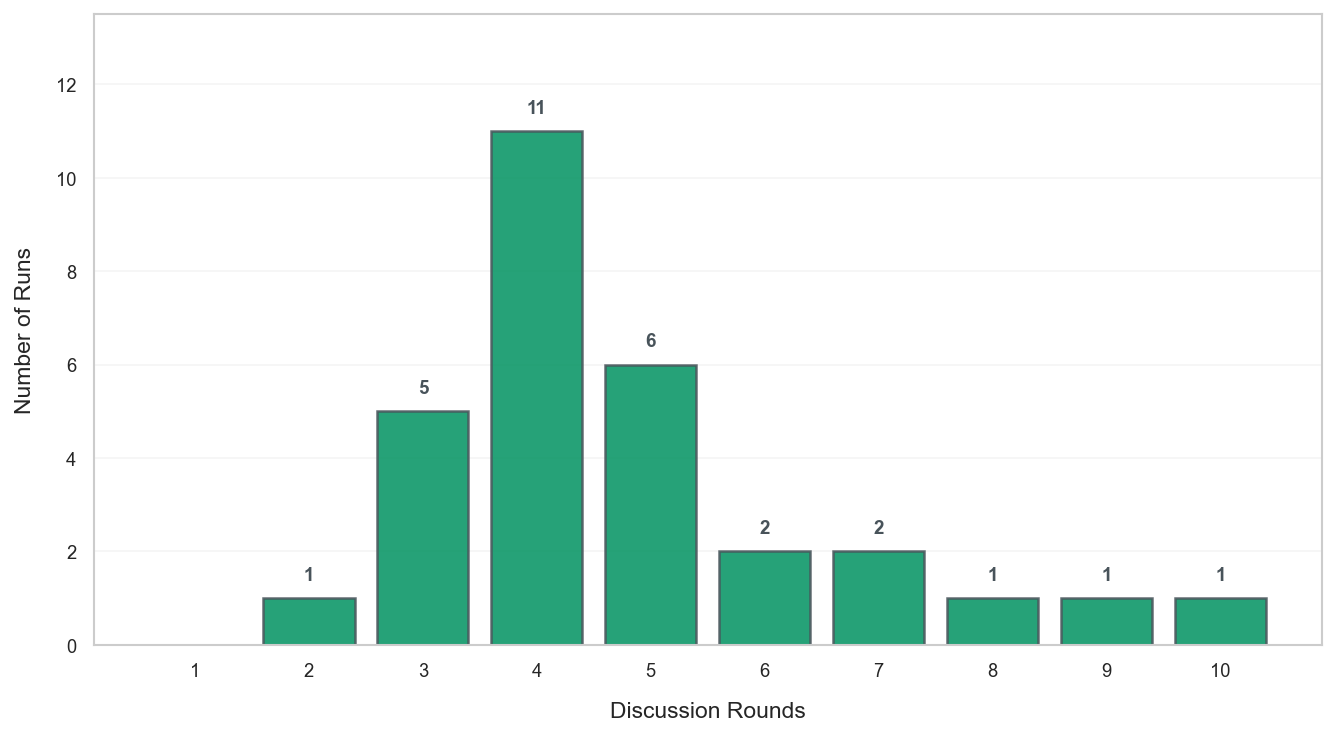


Consensus Timing Summary:
  Total consensus runs: 30
  Range: 2-10 rounds
  Mean: 4.80 rounds  |  Median: 4 rounds


In [26]:
consensus_rounds = run_metrics[(run_metrics["consensus_reached"] == True) & run_metrics["rounds_to_outcome"].notna()].copy()

if consensus_rounds.empty:
    print("No consensus runs with recorded round counts.")
else:
    consensus_rounds["rounds_bucket"] = consensus_rounds["rounds_to_outcome"].astype(int).astype(str)
    ordered_bins = [str(i) for i in range(1, 11)]
    counts = pd.Series({b: 0 for b in ordered_bins})
    counts.update(consensus_rounds["rounds_bucket"].value_counts())
    
    # Show rounds 1 through maximum observed
    max_round = int(consensus_rounds["rounds_to_outcome"].max())
    display_bins = [str(i) for i in range(1, max_round + 1)]
    counts = counts.loc[display_bins]

    fig, ax = plt.subplots(figsize=FIG_SIZES["single"])
    bars = ax.bar(counts.index, counts.values, color=COLORS["primary_green"], 
                  edgecolor=COLORS["dark_gray"], alpha=0.85, linewidth=1.2)

    # Add value labels on bars
    for bar, value in zip(bars, counts.values):
        if value > 0:
            ax.text(bar.get_x() + bar.get_width() / 2, value + 0.3, f"{int(value)}", 
                   ha="center", va="bottom", fontsize=FONT_SIZES["annotation"], 
                   fontweight="bold", color=COLORS["dark_gray"])

    #ax.set_title("Rounds to Consensus Outcome", 
                #fontsize=FONT_SIZES["title"], fontweight="bold", pad=15)
    ax.set_xlabel("Discussion Rounds", fontsize=FONT_SIZES["axis_label"], labelpad=10)
    ax.set_ylabel("Number of Runs", fontsize=FONT_SIZES["axis_label"], labelpad=10)
    ax.set_ylim(0, counts.values.max() + 2.5)
    ax.set_xticks(range(len(counts.index)))
    ax.set_xticklabels(counts.index, rotation=0)

    fig.tight_layout()
    plt.show()
    
    # Print summary statistics
    rounds_values = consensus_rounds["rounds_to_outcome"].values
    print(f"\nConsensus Timing Summary:")
    print(f"  Total consensus runs: {len(rounds_values)}")
    print(f"  Range: {rounds_values.min():.0f}-{rounds_values.max():.0f} rounds")
    print(f"  Mean: {rounds_values.mean():.2f} rounds  |  Median: {np.median(rounds_values):.0f} rounds")

## Preference Evolution and Transitions

The following visualizations track how agents' top-choice preferences change across the four measurement waves, revealing patterns of stability, switching, and long-term loyalty.

In [27]:
# Prepare transition data for top-choice preferences
def build_transition_data(ranking_top_df: pd.DataFrame) -> pd.DataFrame:
    """Build transition data showing how agents' top choices change between waves."""
    # Get all unique agent sessions
    agent_sessions = ranking_top_df[["run_id", "agent"]].drop_duplicates()
    
    transitions = []
    for _, row in agent_sessions.iterrows():
        run_id, agent = row["run_id"], row["agent"]
        agent_data = ranking_top_df[
            (ranking_top_df["run_id"] == run_id) & 
            (ranking_top_df["agent"] == agent)
        ].sort_values("wave_position")
        
        if len(agent_data) >= 4:  # Ensure all 4 waves present
            prefs = agent_data["top_principle_label"].values
            transitions.append({
                "run_id": run_id,
                "agent": agent,
                "wave1": prefs[0],
                "wave2": prefs[1],
                "wave3": prefs[2],
                "wave4": prefs[3]
            })
    
    return pd.DataFrame(transitions)


transition_data = build_transition_data(ranking_top)
print(f"Built transition data for {len(transition_data)} agents")
print(f"\nSample transitions:")
display(transition_data.head(10))

Built transition data for 165 agents

Sample transitions:


,run_id,agent,wave1,wave2,wave3,wave4
0,hypothesis_1_condition_10_config_results,Agent_1,Max Avg + Floor,Max Avg + Floor,Max Avg + Floor,Max Floor
1,hypothesis_1_condition_10_config_results,Agent_2,Max Avg + Floor,Max Avg + Floor,Max Avg + Floor,Max Avg + Floor
2,hypothesis_1_condition_10_config_results,Agent_3,Max Avg + Floor,Max Avg + Floor,Max Avg + Floor,Max Avg + Floor
3,hypothesis_1_condition_10_config_results,Agent_4,Max Avg + Floor,Max Avg + Floor,Max Avg + Floor,Max Avg + Floor
4,hypothesis_1_condition_10_config_results,Agent_5,Max Avg + Floor,Max Avg + Floor,Max Floor,Max Floor
5,hypothesis_1_condition_11_config_results,Agent_1,Max Avg + Floor,Max Avg + Floor,Max Avg + Floor,Max Avg + Floor
6,hypothesis_1_condition_11_config_results,Agent_2,Max Avg + Floor,Max Avg + Floor,Max Avg + Floor,Max Avg + Floor
7,hypothesis_1_condition_11_config_results,Agent_3,Max Avg + Floor,Max Avg + Floor,Max Avg + Floor,Max Avg + Floor
8,hypothesis_1_condition_11_config_results,Agent_4,Max Avg + Floor,Max Avg + Floor,Max Avg + Floor,Max Avg + Floor
9,hypothesis_1_condition_11_config_results,Agent_5,Max Avg + Floor,Max Avg + Floor,Max Avg + Floor,Max Avg + Floor


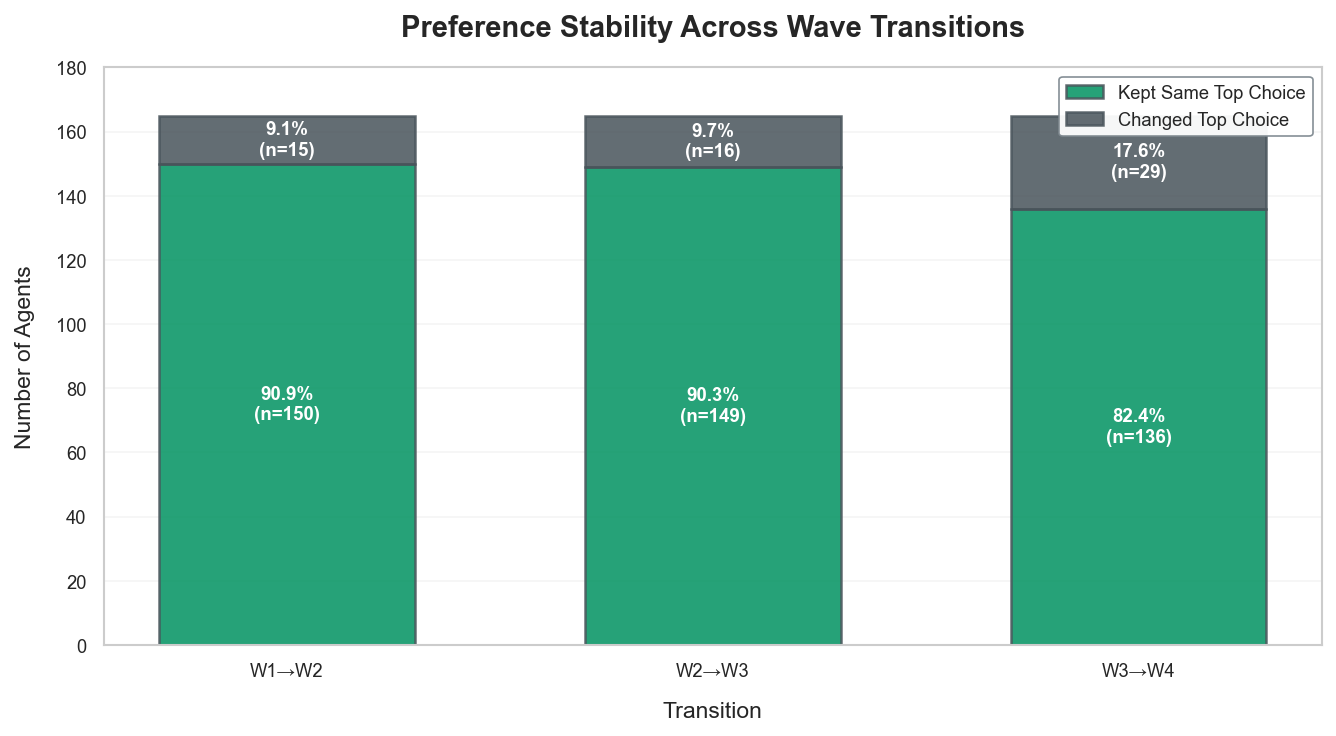


Stability Statistics:


,Transition,Stayed,Switched,Stability %
0,W1→W2,150,15,90.909091
1,W2→W3,149,16,90.303030
2,W3→W4,136,29,82.424242


In [28]:
# VISUALIZATION: Preference Stability Across Transitions

stability_stats = []
for i, (from_wave, to_wave) in enumerate([("wave1", "wave2"), ("wave2", "wave3"), ("wave3", "wave4")], start=1):
    stayed = (transition_data[from_wave] == transition_data[to_wave]).sum()
    switched = len(transition_data) - stayed
    stability_stats.append({
        "Transition": f"W{i}→W{i+1}",
        "Stayed": stayed,
        "Switched": switched,
        "Stability %": (stayed / len(transition_data) * 100)
    })

stability_df = pd.DataFrame(stability_stats)

fig, ax = plt.subplots(figsize=FIG_SIZES["single"])

x = np.arange(len(stability_df))
width = 0.6

# Stacked bars with unified colors
stayed_bars = ax.bar(x, stability_df["Stayed"], width, label="Kept Same Top Choice", 
                     color=COLORS["stayed"], edgecolor=COLORS["dark_gray"], alpha=0.85, linewidth=1.2)
switched_bars = ax.bar(x, stability_df["Switched"], width, bottom=stability_df["Stayed"], 
                       label="Changed Top Choice", color=COLORS["switched"], 
                       edgecolor=COLORS["dark_gray"], alpha=0.85, linewidth=1.2)

# Add percentage labels
for i, row in stability_df.iterrows():
    stayed_pct = row["Stability %"]
    ax.text(i, row["Stayed"]/2, f"{stayed_pct:.1f}%\n(n={int(row['Stayed'])})", 
            ha="center", va="center", fontweight="bold", fontsize=FONT_SIZES["annotation"], color="white")
    
    switched_pct = 100 - stayed_pct
    ax.text(i, row["Stayed"] + row["Switched"]/2, f"{switched_pct:.1f}%\n(n={int(row['Switched'])})", 
            ha="center", va="center", fontweight="bold", fontsize=FONT_SIZES["annotation"], color="white")

ax.set_title("Preference Stability Across Wave Transitions", 
            fontsize=FONT_SIZES["title"], fontweight="bold", pad=15)
ax.set_xlabel("Transition", fontsize=FONT_SIZES["axis_label"], labelpad=10)
ax.set_ylabel("Number of Agents", fontsize=FONT_SIZES["axis_label"], labelpad=10)
ax.set_xticks(x)
ax.set_xticklabels(stability_df["Transition"])
ax.legend(loc="upper right", framealpha=0.95, edgecolor=COLORS["medium_gray"])
ax.set_ylim(0, len(transition_data) + 15)

fig.tight_layout()
plt.show()

print("\nStability Statistics:")
display(stability_df)

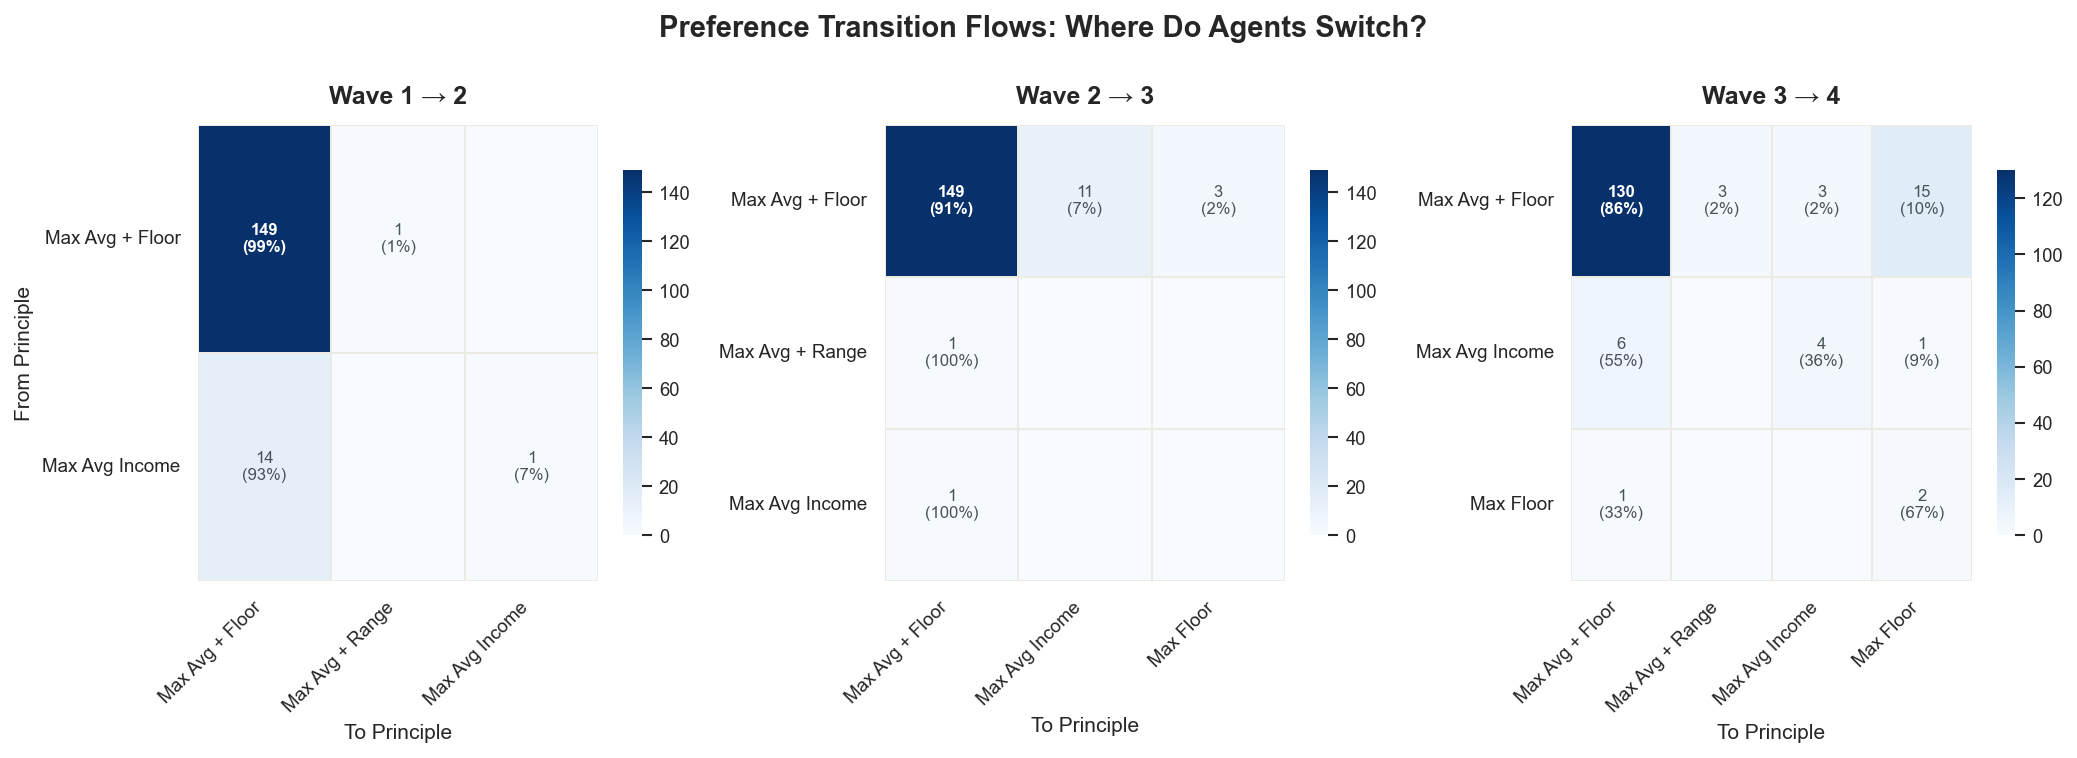


Transition Summary:
  Wave 1 → 2: 149/165 stayed (90.3%)
  Wave 2 → 3: 149/165 stayed (90.3%)
  Wave 3 → 4: 130/165 stayed (78.8%)


In [29]:
# VISUALIZATION: Transition Matrices - Where Do Agents Switch?

def create_transition_matrix(from_col: str, to_col: str) -> pd.DataFrame:
    """Create transition matrix showing flows between principles."""
    matrix = pd.crosstab(transition_data[from_col], transition_data[to_col], margins=False)
    matrix_pct = matrix.div(matrix.sum(axis=1), axis=0) * 100
    return matrix, matrix_pct


transitions = [
    ("wave1", "wave2", "Wave 1 → 2"),
    ("wave2", "wave3", "Wave 2 → 3"),
    ("wave3", "wave4", "Wave 3 → 4")
]

fig, axes = plt.subplots(1, 3, figsize=FIG_SIZES["triple"])

for ax, (from_wave, to_wave, title) in zip(axes, transitions):
    matrix_counts, matrix_pct = create_transition_matrix(from_wave, to_wave)
    
    # Create heatmap with unified colors
    sns.heatmap(matrix_counts, annot=False, fmt="d", cmap="Blues", ax=ax, 
                cbar=True, linewidths=0.8, linecolor=COLORS["light_gray"], 
                vmin=0, cbar_kws={"shrink": 0.8})
    
    # Custom annotations
    for i in range(len(matrix_counts.index)):
        for j in range(len(matrix_counts.columns)):
            count = matrix_counts.iloc[i, j]
            pct = matrix_pct.iloc[i, j]
            
            if i == j and count > 0:  # Diagonal (stayed)
                text = f"{int(count)}\n({pct:.0f}%)"
                weight = "bold"
                color = "white" if count > matrix_counts.values.max() * 0.6 else COLORS["dark_gray"]
            elif count > 0:
                text = f"{int(count)}\n({pct:.0f}%)"
                weight = "normal"
                color = "white" if count > matrix_counts.values.max() * 0.6 else COLORS["dark_gray"]
            else:
                text = ""
                weight = "normal"
                color = COLORS["dark_gray"]
            
            ax.text(j + 0.5, i + 0.5, text, ha="center", va="center", 
                   fontsize=FONT_SIZES["annotation"]-1, fontweight=weight, color=color)
    
    ax.set_title(title, fontsize=FONT_SIZES["subtitle"], fontweight="bold", pad=10)
    ax.set_xlabel("To Principle", fontsize=FONT_SIZES["tick_label"])
    ax.set_ylabel("From Principle" if ax == axes[0] else "", fontsize=FONT_SIZES["tick_label"])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=FONT_SIZES["annotation"])
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=FONT_SIZES["annotation"])

fig.suptitle("Preference Transition Flows: Where Do Agents Switch?", 
             fontsize=FONT_SIZES["title"], fontweight="bold", y=1.00)
fig.tight_layout()
plt.show()

# Print insights
print("\nTransition Summary:")
for from_wave, to_wave, title in transitions:
    matrix_counts, _ = create_transition_matrix(from_wave, to_wave)
    diagonal_sum = sum([matrix_counts.iloc[i, i] for i in range(min(len(matrix_counts), len(matrix_counts.columns)))])
    total = matrix_counts.values.sum()
    print(f"  {title}: {diagonal_sum}/{total} stayed ({diagonal_sum/total*100:.1f}%)")

In [30]:
# VISUALIZATION: Long-Term Preference Stability (Wave 1 → Wave 4)

principle_order = [
    "Max Floor",
    "Max Avg Income",
    "Max Avg + Floor",
    "Max Avg + Range"
]

principle_display_order = format_principle_labels(principle_order)

In [31]:
# VISUALIZATION: Long-Term Preference Stability Counts with Margins
principle_order = [
    "Max Floor",
    "Max Avg Income",
    "Max Avg + Floor",
    "Max Avg + Range"
]

principle_display_order = format_principle_labels(principle_order)

## Switcher Analysis: Income Class and Preference Changes

The following analysis investigates whether agents who changed their top-choice preferences have different income class assignments compared to those who remained loyal to their initial preference.

In [32]:
# Extract income class assignments from Phase 2 post_group_discussion
def extract_income_classes(runs: List[Tuple[str, Dict[str, Any]]]) -> pd.DataFrame:
    """Extract income class assignment for each agent from Phase 2."""
    income_data = []
    
    for run_id, run_data in runs:
        agents = run_data.get("agents", [])
        for agent in agents:
            agent_name = agent.get("name")
            phase2 = agent.get("phase_2", {})
            post_group = phase2.get("post_group_discussion", {})
            
            # Get class assignment (correct location!)
            class_assigned = post_group.get("class_put_in", None)
            
            income_data.append({
                "run_id": run_id,
                "agent": agent_name,
                "income_class_raw": class_assigned
            })
    
    return pd.DataFrame(income_data)


# Standardize income class labels
def standardize_income_class(raw_class: str) -> str:
    """Standardize income class labels."""
    if raw_class is None or pd.isna(raw_class):
        return "Unknown"
    
    class_map = {
        "low": "Low",
        "medium_low": "Medium-Low",
        "medium": "Medium",
        "medium_high": "Medium-High",
        "high": "High"
    }
    
    return class_map.get(str(raw_class).lower(), "Unknown")


# Extract income data with CORRECT location
income_df = extract_income_classes(runs)
income_df["income_class"] = income_df["income_class_raw"].apply(standardize_income_class)

print(f"Extracted income data for {len(income_df)} agents")
print(f"\nIncome class distribution:")
income_counts = income_df["income_class"].value_counts().sort_index()
print(income_counts)
print(f"\nPercentages:")
print((income_counts / income_counts.sum() * 100).round(1))

# Show sample
display(income_df.head(15))

Extracted income data for 165 agents

Income class distribution:
income_class
High            7
Low            15
Medium         88
Medium-High    16
Medium-Low     39
Name: count, dtype: int64

Percentages:
income_class
High            4.2
Low             9.1
Medium         53.3
Medium-High     9.7
Medium-Low     23.6
Name: count, dtype: float64


,run_id,agent,income_class_raw,income_class
0,hypothesis_1_condition_10_config_results,Agent_1,low,Low
1,hypothesis_1_condition_10_config_results,Agent_2,medium,Medium
2,hypothesis_1_condition_10_config_results,Agent_3,medium,Medium
3,hypothesis_1_condition_10_config_results,Agent_4,medium_low,Medium-Low
4,hypothesis_1_condition_10_config_results,Agent_5,medium,Medium
5,hypothesis_1_condition_11_config_results,Agent_1,medium_low,Medium-Low
6,hypothesis_1_condition_11_config_results,Agent_2,medium_low,Medium-Low
7,hypothesis_1_condition_11_config_results,Agent_3,medium,Medium
8,hypothesis_1_condition_11_config_results,Agent_4,medium,Medium
9,hypothesis_1_condition_11_config_results,Agent_5,medium_low,Medium-Low


In [33]:
# Merge income data with transition data
switcher_analysis = transition_data.merge(income_df, on=["run_id", "agent"], how="left")

# Identify switchers: agents who changed their top choice at ANY point
switcher_analysis["switched_w1_w2"] = switcher_analysis["wave1"] != switcher_analysis["wave2"]
switcher_analysis["switched_w2_w3"] = switcher_analysis["wave2"] != switcher_analysis["wave3"]
switcher_analysis["switched_w3_w4"] = switcher_analysis["wave3"] != switcher_analysis["wave4"]
switcher_analysis["switched_any"] = (
    switcher_analysis["switched_w1_w2"] | 
    switcher_analysis["switched_w2_w3"] | 
    switcher_analysis["switched_w3_w4"]
)
switcher_analysis["switched_w1_w4"] = switcher_analysis["wave1"] != switcher_analysis["wave4"]

# Count switches per agent
switcher_analysis["num_switches"] = (
    switcher_analysis["switched_w1_w2"].astype(int) +
    switcher_analysis["switched_w2_w3"].astype(int) +
    switcher_analysis["switched_w3_w4"].astype(int)
)

# Categorize agents
def categorize_switcher(row):
    if row["num_switches"] == 0:
        return "Loyal (No switches)"
    elif row["num_switches"] == 1:
        return "Minor switcher (1 switch)"
    elif row["num_switches"] == 2:
        return "Moderate switcher (2 switches)"
    else:
        return "Major switcher (3+ switches)"

switcher_analysis["switcher_category"] = switcher_analysis.apply(categorize_switcher, axis=1)

# Summary statistics
print("=" * 80)
print("SWITCHER ANALYSIS SUMMARY")
print("=" * 80)
print(f"\nTotal agents analyzed: {len(switcher_analysis)}")
print(f"Agents who switched at ANY point: {switcher_analysis['switched_any'].sum()} ({switcher_analysis['switched_any'].sum()/len(switcher_analysis)*100:.1f}%)")
print(f"Agents who stayed loyal (W1→W4): {(~switcher_analysis['switched_w1_w4']).sum()} ({(~switcher_analysis['switched_w1_w4']).sum()/len(switcher_analysis)*100:.1f}%)")

print("\n\nSwitcher Category Distribution:")
print(switcher_analysis["switcher_category"].value_counts().sort_index())

print("\n\nSwitches by Transition:")
print(f"  W1→W2: {switcher_analysis['switched_w1_w2'].sum()} agents switched")
print(f"  W2→W3: {switcher_analysis['switched_w2_w3'].sum()} agents switched")
print(f"  W3→W4: {switcher_analysis['switched_w3_w4'].sum()} agents switched")

display(switcher_analysis.head(15))

SWITCHER ANALYSIS SUMMARY

Total agents analyzed: 165
Agents who switched at ANY point: 45 (27.3%)
Agents who stayed loyal (W1→W4): 131 (79.4%)


Switcher Category Distribution:
switcher_category
Loyal (No switches)               120
Minor switcher (1 switch)          30
Moderate switcher (2 switches)     15
Name: count, dtype: int64


Switches by Transition:
  W1→W2: 15 agents switched
  W2→W3: 16 agents switched
  W3→W4: 29 agents switched


,run_id,agent,wave1,wave2,wave3,wave4,income_class_raw,income_class,switched_w1_w2,switched_w2_w3,switched_w3_w4,switched_any,switched_w1_w4,num_switches,switcher_category
0,hypothesis_1_condition_10_config_results,Agent_1,Max Avg + Floor,Max Avg + Floor,Max Avg + Floor,Max Floor,low,Low,False,False,True,True,True,1,Minor switcher (1 switch)
1,hypothesis_1_condition_10_config_results,Agent_2,Max Avg + Floor,Max Avg + Floor,Max Avg + Floor,Max Avg + Floor,medium,Medium,False,False,False,False,False,0,Loyal (No switches)
2,hypothesis_1_condition_10_config_results,Agent_3,Max Avg + Floor,Max Avg + Floor,Max Avg + Floor,Max Avg + Floor,medium,Medium,False,False,False,False,False,0,Loyal (No switches)
3,hypothesis_1_condition_10_config_results,Agent_4,Max Avg + Floor,Max Avg + Floor,Max Avg + Floor,Max Avg + Floor,medium_low,Medium-Low,False,False,False,False,False,0,Loyal (No switches)
4,hypothesis_1_condition_10_config_results,Agent_5,Max Avg + Floor,Max Avg + Floor,Max Floor,Max Floor,medium,Medium,False,True,False,True,True,1,Minor switcher (1 switch)
5,hypothesis_1_condition_11_config_results,Agent_1,Max Avg + Floor,Max Avg + Floor,Max Avg + Floor,Max Avg + Floor,medium_low,Medium-Low,False,False,False,False,False,0,Loyal (No switches)
6,hypothesis_1_condition_11_config_results,Agent_2,Max Avg + Floor,Max Avg + Floor,Max Avg + Floor,Max Avg + Floor,medium_low,Medium-Low,False,False,False,False,False,0,Loyal (No switches)
7,hypothesis_1_condition_11_config_results,Agent_3,Max Avg + Floor,Max Avg + Floor,Max Avg + Floor,Max Avg + Floor,medium,Medium,False,False,False,False,False,0,Loyal (No switches)
8,hypothesis_1_condition_11_config_results,Agent_4,Max Avg + Floor,Max Avg + Floor,Max Avg + Floor,Max Avg + Floor,medium,Medium,False,False,False,False,False,0,Loyal (No switches)
9,hypothesis_1_condition_11_config_results,Agent_5,Max Avg + Floor,Max Avg + Floor,Max Avg + Floor,Max Avg + Floor,medium_low,Medium-Low,False,False,False,False,False,0,Loyal (No switches)


In [34]:
# TABLE: Income Class Distribution by Preference Stability Outcome

# Create comparison table
switchers = switcher_analysis[switcher_analysis["switched_any"] == True]
maintainers = switcher_analysis[switcher_analysis["switched_any"] == False]

income_comparison = pd.DataFrame({
    "Income Class": ["Low", "Medium-Low", "Medium", "Medium-High", "High"],
})

# Calculate counts and percentages for agents who changed preference
switcher_income_counts = switchers["income_class"].value_counts()
income_comparison["Changed Preference Count"] = income_comparison["Income Class"].map(switcher_income_counts).fillna(0).astype(int)
income_comparison["Changed Preference %"] = (income_comparison["Changed Preference Count"] / len(switchers) * 100).round(1)

# Calculate counts and percentages for agents who maintained preference
maintainer_income_counts = maintainers["income_class"].value_counts()
income_comparison["Maintained Preference Count"] = income_comparison["Income Class"].map(maintainer_income_counts).fillna(0).astype(int)
income_comparison["Maintained Preference %"] = (income_comparison["Maintained Preference Count"] / len(maintainers) * 100).round(1)

# Calculate difference between groups (percentage points)
income_comparison["Diff Changed vs Maintained (pp)"] = (income_comparison["Changed Preference %"] - income_comparison["Maintained Preference %"]).round(1)

print("=" * 90)
print("INCOME CLASS DISTRIBUTION BY PREFERENCE STABILITY")
print("=" * 90)
print(f"Changed preference: {len(switchers)} agents | Maintained preference: {len(maintainers)} agents")
print("=" * 90)
display(income_comparison)

INCOME CLASS DISTRIBUTION BY PREFERENCE STABILITY
Changed preference: 45 agents | Maintained preference: 120 agents


,Income Class,Changed Preference Count,Changed Preference %,Maintained Preference Count,Maintained Preference %,Diff Changed vs Maintained (pp)
0,Low,12,26.7,3,2.5,24.2
1,Medium-Low,13,28.9,26,21.7,7.2
2,Medium,18,40.0,70,58.3,-18.3
3,Medium-High,2,4.4,14,11.7,-7.3
4,High,0,0.0,7,5.8,-5.8


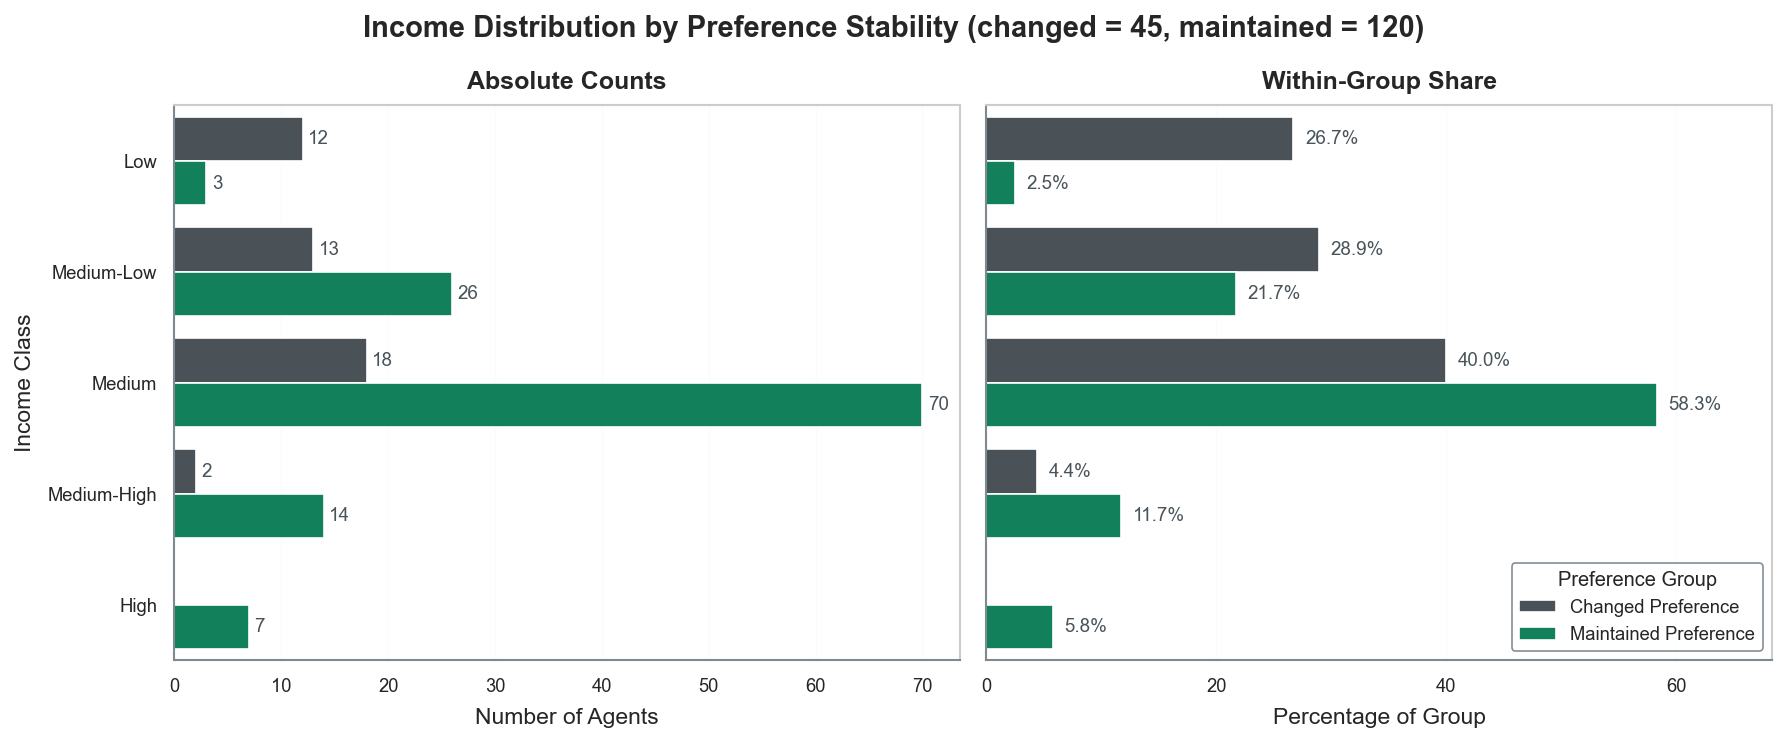

In [35]:
# VISUALIZATION: Preference Stability by Income Class (aligned layout)
category_order = income_comparison["Income Class"].tolist()

count_columns = {
    "Changed Preference Count": "Changed Preference",
    "Maintained Preference Count": "Maintained Preference",
}
share_columns = {
    "Changed Preference %": "Changed Preference",
    "Maintained Preference %": "Maintained Preference",
}

count_wide = income_comparison[["Income Class", *count_columns.keys()]].rename(columns=count_columns)
share_wide = income_comparison[["Income Class", *share_columns.keys()]].rename(columns=share_columns)

count_long = count_wide.melt(
    id_vars="Income Class",
    value_vars=list(count_columns.values()),
    var_name="Preference Group",
    value_name="Count"
)

share_long = share_wide.melt(
    id_vars="Income Class",
    value_vars=list(share_columns.values()),
    var_name="Preference Group",
    value_name="Share"
)

fig, axes = plt.subplots(ncols=2, figsize=FIG_SIZES["double"], sharey=True)
palette = [COLORS["switched"], COLORS["stayed"]]

sns.barplot(
    data=count_long,
    x="Count",
    y="Income Class",
    hue="Preference Group",
    order=category_order,
    hue_order=["Changed Preference", "Maintained Preference"],
    orient="h",
    palette=palette,
    ax=axes[0]
)

sns.barplot(
    data=share_long,
    x="Share",
    y="Income Class",
    hue="Preference Group",
    order=category_order,
    hue_order=["Changed Preference", "Maintained Preference"],
    orient="h",
    palette=palette,
    ax=axes[1]
)

axes[0].set_title("Absolute Counts", fontsize=FONT_SIZES["subtitle"], fontweight="bold", pad=8)
axes[0].set_xlabel("Number of Agents", fontsize=FONT_SIZES["axis_label"], labelpad=6)
axes[0].set_ylabel("Income Class", fontsize=FONT_SIZES["axis_label"], labelpad=6)
axes[0].grid(axis="x", color=COLORS["light_gray"], linewidth=0.6)
if axes[0].legend_:
    axes[0].legend_.remove()

axes[1].set_title("Within-Group Share", fontsize=FONT_SIZES["subtitle"], fontweight="bold", pad=8)
axes[1].set_xlabel("Percentage of Group", fontsize=FONT_SIZES["axis_label"], labelpad=6)
axes[1].set_ylabel("", fontsize=FONT_SIZES["axis_label"])
axes[1].grid(axis="x", color=COLORS["light_gray"], linewidth=0.6)
share_limit = min(100, share_long["Share"].max() + 10)
axes[1].set_xlim(0, share_limit)
axes[1].set_xticks(np.arange(0, share_limit + 1, 20))
axes[1].legend(title="Preference Group", framealpha=0.95, edgecolor=COLORS["medium_gray"], loc="lower right")

for ax in axes:
    ax.spines["left"].set_color(COLORS["medium_gray"])
    ax.spines["bottom"].set_color(COLORS["medium_gray"])
    for patch in ax.patches:
        value = patch.get_width()
        if value <= 0:
            continue
        y = patch.get_y() + patch.get_height() / 2
        label = f"{value:.0f}" if ax is axes[0] else f"{value:.1f}%"
        offset = 0.5 if ax is axes[0] else 1.0
        ax.text(
            value + offset,
            y,
            label,
            va="center",
            ha="left",
            fontsize=FONT_SIZES["annotation"],
            color=COLORS["dark_gray"],
        )

fig.suptitle(
    f"Income Distribution by Preference Stability (changed = {len(switchers)}, maintained = {len(maintainers)})",
    fontsize=FONT_SIZES["title"],
    fontweight="bold",
    y=0.98
)
fig.tight_layout()
plt.show()

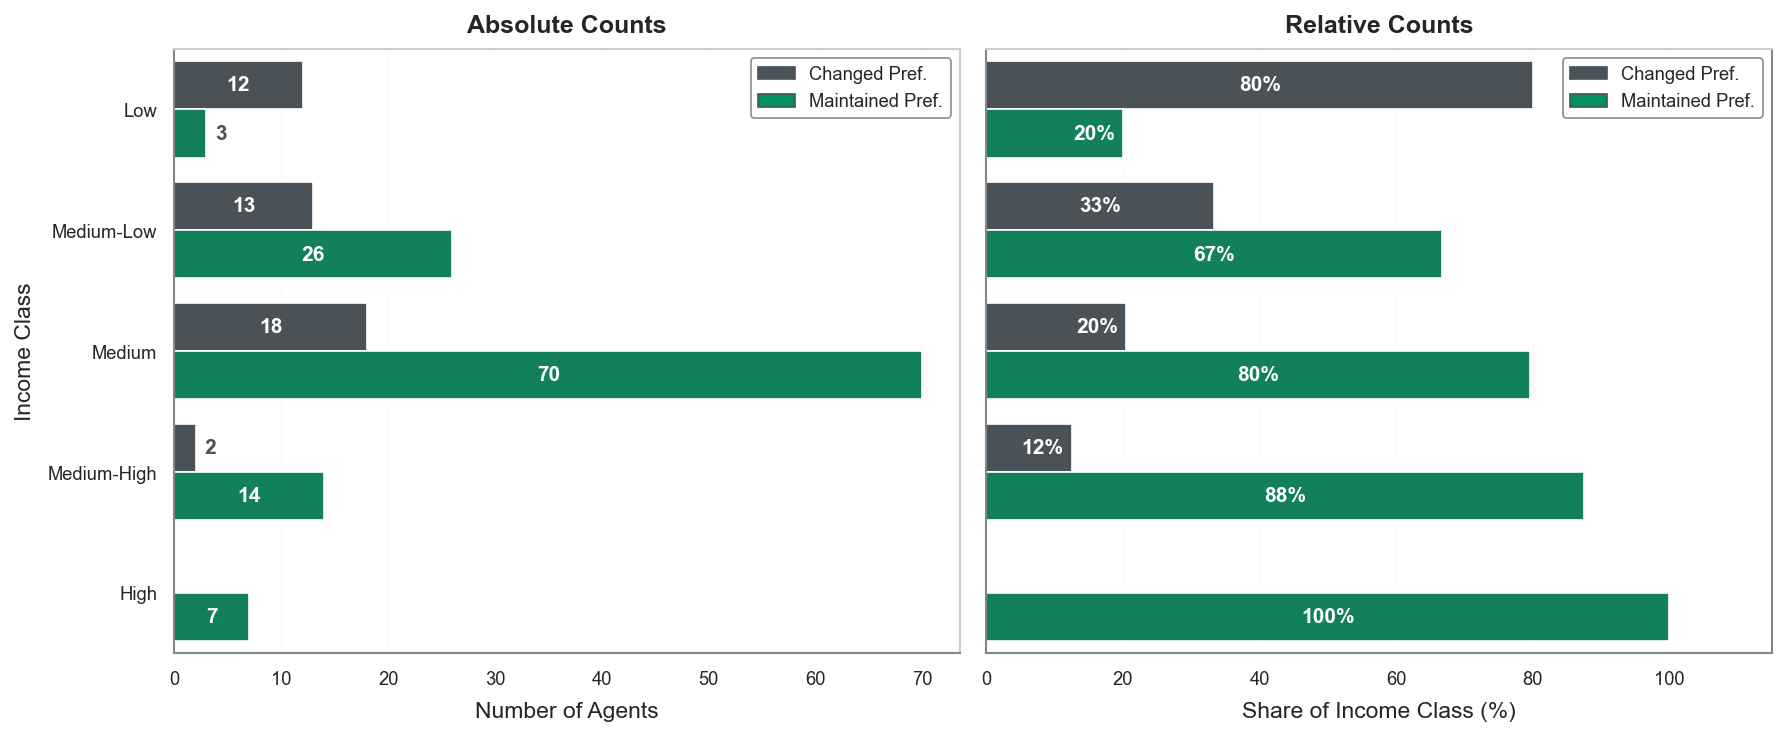

In [36]:
# VISUALIZATION: Preference Stability Composition by Income Class
from matplotlib.patches import Patch

composition_summary = income_comparison.copy()
composition_summary["Total Agents"] = (
    composition_summary["Changed Preference Count"] + composition_summary["Maintained Preference Count"]
)

composition_long = composition_summary.melt(
    id_vars=["Income Class", "Total Agents"],
    value_vars=["Changed Preference Count", "Maintained Preference Count"],
    var_name="Preference Group",
    value_name="Count"
)

composition_long["Preference Group"] = composition_long["Preference Group"].replace({
    "Changed Preference Count": "Changed Preference",
    "Maintained Preference Count": "Maintained Preference"
})
composition_long["Percent"] = np.where(
    composition_long["Total Agents"] > 0,
    (composition_long["Count"] / composition_long["Total Agents"]) * 100,
    0
)

composition_percent_long = composition_long[["Income Class", "Preference Group", "Percent"]].copy()

fig, axes = plt.subplots(ncols=2, figsize=FIG_SIZES["double"], sharey=True)
palette = [COLORS["switched"], COLORS["stayed"]]

sns.barplot(
    data=count_long,
    x="Count",
    y="Income Class",
    hue="Preference Group",
    order=category_order,
    hue_order=["Changed Preference", "Maintained Preference"],
    orient="h",
    palette=palette,
    ax=axes[0]
)

axes[0].set_title("Absolute Counts", fontsize=FONT_SIZES["subtitle"], fontweight="bold", pad=8)
axes[0].set_xlabel("Number of Agents", fontsize=FONT_SIZES["axis_label"], labelpad=6)
axes[0].set_ylabel("Income Class", fontsize=FONT_SIZES["axis_label"], labelpad=6)
axes[0].grid(axis="x", color=COLORS["light_gray"], linewidth=0.6)
if axes[0].legend_:
    axes[0].legend_.remove()
axes[0].spines["left"].set_color(COLORS["medium_gray"])
axes[0].spines["bottom"].set_color(COLORS["medium_gray"])

legend_handles = [
    Patch(facecolor=COLORS["switched"], edgecolor=COLORS["primary_blue"], label="Changed Pref."),
    Patch(facecolor=COLORS["stayed"], edgecolor=COLORS["primary_blue"], label="Maintained Pref."),
]
axes[0].legend(handles=legend_handles, framealpha=0.95, edgecolor=COLORS["medium_gray"], loc="upper right")

for patch, (income_class, group, count) in zip(
    axes[0].patches,
    count_long[["Income Class", "Preference Group", "Count"]].itertuples(index=False)
):
    if count <= 0:
        continue
    y = patch.get_y() + patch.get_height() / 2
    width = patch.get_width()
    if (group == "Maintained Preference" and count <= 6) or (group == "Changed Preference" and income_class == "Medium-High"):
        x = patch.get_x() + width + 0.8
        ha = "left"
        color = COLORS["dark_gray"]
    else:
        x = patch.get_x() + width / 2
        ha = "center"
        color = COLORS["background"]
    axes[0].text(
        x,
        y,
        f"{int(count)}",
        va="center",
        ha=ha,
        fontsize=FONT_SIZES["annotation"] + 1,
        fontweight="bold",
        color=color
    )

sns.barplot(
    data=composition_percent_long,
    x="Percent",
    y="Income Class",
    hue="Preference Group",
    order=category_order,
    hue_order=["Changed Preference", "Maintained Preference"],
    orient="h",
    palette=palette,
    ax=axes[1]
)

axes[1].set_title("Relative Counts", fontsize=FONT_SIZES["subtitle"], fontweight="bold", pad=8)
axes[1].set_xlabel("Share of Income Class (%)", fontsize=FONT_SIZES["axis_label"], labelpad=6)
axes[1].set_ylabel("")
axes[1].set_xlim(0, 115)
axes[1].grid(axis="x", color=COLORS["light_gray"], linewidth=0.6)
axes[1].spines["left"].set_color(COLORS["medium_gray"])
axes[1].spines["bottom"].set_color(COLORS["medium_gray"])
axes[1].spines["top"].set_visible(True)
axes[1].spines["right"].set_color(COLORS["medium_gray"])
axes[1].spines["right"].set_visible(True)

for patch, percent in zip(axes[1].patches, composition_percent_long["Percent"]):
    if percent <= 0:
        continue
    y = patch.get_y() + patch.get_height() / 2
    if percent >= 30:
        x = patch.get_x() + percent / 2
        ha = "center"
        color = COLORS["background"]
    else:
        x = patch.get_x() + max(percent - 1.2, 0.8)
        ha = "right"
        color = COLORS["background"] if percent >= 12 else COLORS["dark_gray"]
    axes[1].text(
        x,
        y,
        f"{percent:.0f}%",
        va="center",
        ha=ha,
        fontsize=FONT_SIZES["annotation"] + 1,
        fontweight="bold",
        color=color
    )

legend_handles = [
    Patch(facecolor=COLORS["switched"], edgecolor=COLORS["primary_blue"], label="Changed Pref."),
    Patch(facecolor=COLORS["stayed"], edgecolor=COLORS["primary_blue"], label="Maintained Pref."),
]
axes[1].legend(handles=legend_handles, framealpha=0.95, edgecolor=COLORS["medium_gray"], loc="upper right")

fig.tight_layout()
plt.show()

# Stuff

In [44]:
import yaml
from collections import Counter
from pathlib import Path

# ============================================================================
# LLM MODEL USAGE ANALYSIS
# ============================================================================

# Extract models from all config files
config_dir = PROJECT_ROOT / "hypothesis_testing" / "hypothesis_1" / "configs"
configs_found = list(config_dir.glob("*.yaml"))

participant_models = []
utility_models = []

for config_file in sorted(configs_found):
    with open(config_file, 'r') as f:
        config = yaml.safe_load(f)
    
    # Extract participant agent models
    if 'agents' in config:
        for agent in config['agents']:
            if 'model' in agent:
                participant_models.append(agent['model'])
    
    # Extract utility agent model
    if 'utility_agent_model' in config:
        utility_models.append(config['utility_agent_model'])

# Count occurrences
participant_model_counts = Counter(participant_models)
utility_model_counts = Counter(utility_models)

print("=" * 80)
print("LLM MODEL USAGE ACROSS HYPOTHESIS 1 CONFIGURATIONS")
print("=" * 80)
print(f"\nTotal config files analyzed: {len(configs_found)}")
print(f"Total participant agent slots: {len(participant_models)}")
print(f"Total utility agent slots: {len(utility_models)}")

print("\n" + "=" * 80)
print("PARTICIPANT AGENTS - MODEL DISTRIBUTION")
print("=" * 80)

participant_rows = []
for model, count in sorted(participant_model_counts.items(), key=lambda x: x[1], reverse=True):
    pct = (count / len(participant_models)) * 100
    participant_rows.append({"Model": model, "Count": count, "Percentage": f"{pct:.1f}%"})

participant_summary = pd.DataFrame(participant_rows)
display(participant_summary)




LLM MODEL USAGE ACROSS HYPOTHESIS 1 CONFIGURATIONS

Total config files analyzed: 33
Total participant agent slots: 165
Total utility agent slots: 33

PARTICIPANT AGENTS - MODEL DISTRIBUTION


,Model,Count,Percentage
0,gemini-2.5-flash,59,35.8%
1,gemini-2.5-pro,58,35.2%
2,gemini-2.5-flash-lite,48,29.1%


In [49]:
average_aa_score = 0.358*60 + 0.352*47 + 0.291*42 
print(average_aa_score)

50.246


In [48]:
print(participant_model_counts[1])

0


In [38]:
df = switcher_analysis.copy()

In [39]:
df.shape

(165, 15)

In [40]:
df_floor=df[df["wave4"] == "Max Floor"]


In [41]:
count_low = 0
count_med_low = 0
count_med = 0
count_med_high = 0
count_high = 0

df_floor = df_floor.reset_index()
for index, row in df_floor.iterrows():
    if row["income_class"] == "Low":
        count_low += 1
    elif row["income_class"] == "Medium-Low":
        count_med_low += 1
    elif row["income_class"] == "Medium":
        count_med += 1
    elif row["income_class"] == "Medium-High":
        count_med_high += 1
    elif row["income_class"] == "High":
        count_high += 1
print("Low: ", count_low)
print("Medium-Low: ", count_med_low)
print("Medium: ", count_med)
print("Medium-High: ", count_med_high)
print("High: ", count_high)


Low:  9
Medium-Low:  6
Medium:  2
Medium-High:  1
High:  0
